In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter
import cv2
from scipy import spatial

In [2]:
def binarize(gray_image, thresh_val):

    gray_copy = gray_image.copy()
    gray_copy = gaussian_filter(gray_copy, sigma=1)
    mask = gray_copy > thresh_val
    binary_image = mask.astype(np.uint8) * 255
    return binary_image

def label(binary_image):
    """ Function to labeled components in a binary image
        Uses a sequential labeling algorithm

        Args:
        - binary_image: binary image with multiple components to label

        Return:
        - lab_im: binary image with grayscale level as label of component
    """

    _, lab_im = cv2.connectedComponents(binary_image)     
    return lab_im

def process_triangle(img_tri1):
    kernel = np.ones((25,25), dtype = 'uint8')
    image_erode = cv2.erode(img_tri1, kernel)      

    blurred = gaussian_filter(image_erode, sigma=3)
#     plt.imshow(blurred, cmap='gray')
    return blurred

def process_hand(img_tri1):
    kernel = np.ones((25,25), dtype = 'uint8')
    image_dilate = cv2.dilate(img_tri1, kernel)      

    blurred = gaussian_filter(image_dilate, sigma=3)
#     plt.imshow(blurred, cmap='gray')
    return blurred

def triangles(bin_img):
    blurred_img = process_hand(bin_img)
    plt.imshow(blurred_img, 'gray')
    points_x, points_y = np.where(blurred_img == 255)
    points = np.c_[ points_y, points_x ]    
    
    hull = spatial.ConvexHull(points)

    plt.imshow(blurred_img)
    plt.plot(points[hull.vertices,0], points[hull.vertices,1], 'r--', lw=2)
    plt.plot(np.array([points[hull.vertices,0][-1], points[hull.vertices,0][0]]), 
             np.array([points[hull.vertices,1][-1], points[hull.vertices,1][0]]), 'r--', lw=2)
    plt.show()

    outline = np.c_[ points[hull.vertices,0], points[hull.vertices,1] ]
    mask = np.zeros((bin_img.shape))
    mask = cv2.fillPoly(mask, [np.int32(outline)], (255, 255, 255))

    mask = mask != 255

    mask_int = mask.astype('int')
    out_img = blurred_img.copy()
    out_img[mask] = 0
    # plt.imshow(mask_int*255 - bin_img)
    # plt.colorbar()

    triangles = (mask_int*255 - bin_img) == 0
    img_tri = blurred_img.copy()
    out_tri = (mask_int*255 - bin_img) != 0
    img_tri[out_tri] = 255    
    
    hull_points = np.zeros(bin_img.shape)

    for p1, p2 in zip(points[hull.vertices,0], points[hull.vertices,1]):
    #     print(p1,p2)
        hull_points = cv2.circle(hull_points,(p1,p2), 50, 255, -1)
#     plt.imshow(hull_points)     
    
    return img_tri, hull_points


def detect_corners(blurred):
    dst = cv2.cornerHarris(blurred,10,3,0.08)
    dst = cv2.dilate(dst,None)
    r,c = np.where(dst>0.01*dst.max())
    
    c_img = np.zeros(blurred.shape)
    i = 0
    prev_pt = (0,0)
    for ri,ci in zip(r,c):
        if i == 0:
            prev_pt = (ci, ri)
            i += 1
            continue

        c_img = cv2.circle(c_img, (ci, ri), 8, 255, -1)
    img_points = label(c_img.astype('uint8'))
    return img_points

def acute_triangle(img_points):
    prev_pt = np.array([0,0])
    numLabels = np.max(np.unique(img_points))
#     print(numLabels)
    temp_img = img_points.copy()
    if (numLabels == 0):
        return False
    for i in range(2, np.max(np.unique(img_points)) + 2):
        if i == 2:
            rows, cols = np.where(img_points == 1)
            center_x = np.mean(cols).astype('int')
            center_y = np.mean(rows).astype('int')   
            prev_pt1 = np.array([center_x, center_y])

            rows, cols = np.where(img_points == 2)
            center_x = np.mean(cols).astype('int')
            center_y = np.mean(rows).astype('int')   
            prev_pt2 = np.array([center_x, center_y])   

        index = (i % np.max(np.unique(img_points))) + 1
        rows, cols = np.where(img_points == index)
        center_x = np.mean(cols).astype('int')
        center_y = np.mean(rows).astype('int')   
        curr_pt = np.array([center_x, center_y])

        ba = curr_pt - prev_pt2
        bc = prev_pt1 - prev_pt2
        cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
        angle = np.arccos(cosine_angle)
#         print(np.degrees(angle)    )
        if (np.degrees(angle) > 110):
            return False

        temp_img = cv2.line(temp_img, (prev_pt1[0], prev_pt1[1]), 
                            (prev_pt2[0], prev_pt2[1]), (255,0,0), 2)     
#         plt.imshow(temp_img)
#         plt.show()
        prev_pt1 = prev_pt2 
        prev_pt2 = curr_pt    
    return True

def count_acute_triangles(labeled_img):
    # iterate through triangles 
    numAcute = 0
    for i in np.unique(labeled_img)[1:]:
        img_tri1 = labeled_img.copy()
        img_tri1 = img_tri1 == i
        img_tri1 = img_tri1.astype('uint8')* 255    

        blurred = process_triangle(img_tri1)
        img_points = detect_corners(blurred)
        acute = acute_triangle(img_points)
        if (acute):
            numAcute += 1
#     print(numAcute)     
    return numAcute
#     print(obtuse)

def is_on_hull(point, is_hull_points):
    if is_hull_points[point[1], point[0]]:
        return True
    return False

def finger_triangle(img_points, is_hull_points):
    num_hull = 0
    num_direction_change = 0
    prev_pt = np.array([0,0])
    numLabels = np.max(np.unique(img_points))
#     print(numLabels)
    temp_img = img_points.copy()
    if (numLabels == 0):
        return False
    for i in range(2, np.max(np.unique(img_points)) + np.max(np.unique(img_points)) - 1):
#         print('loop')
        if i == 2:
            rows, cols = np.where(img_points == 1)
            center_x = np.mean(cols).astype('int')
            center_y = np.mean(rows).astype('int')   
            prev_pt1 = np.array([center_x, center_y])

            rows, cols = np.where(img_points == 2)
            center_x = np.mean(cols).astype('int')
            center_y = np.mean(rows).astype('int')   
            prev_pt2 = np.array([center_x, center_y])   

        index = (i % np.max(np.unique(img_points))) + 1
        rows, cols = np.where(img_points == index)
        center_x = np.mean(cols).astype('int')
        center_y = np.mean(rows).astype('int')   
        curr_pt = np.array([center_x, center_y])
        
        if is_on_hull(prev_pt1, is_hull_points):
            num_hull += 1
        
        
        ba = curr_pt - prev_pt2
        bc = prev_pt1 - prev_pt2
        cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
        angle = np.arccos(cosine_angle)
#         print(np.degrees(angle)    )
        thres = 20
        if not(np.degrees(angle) > 180 - thres and np.degrees(angle) < 180 + thres):
            num_direction_change += 1


        prev_pt1 = prev_pt2 
        prev_pt2 = curr_pt    

    if (num_direction_change >= 3 and num_hull >= 2):
        return True
    else:
        return False
    
def detect_fingers(img):
    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # from scipy.ndimage import gaussian_filter
    bin_img = binarize(gray_image, 200)
    img_tri, hull_points = triangles(bin_img)



    kernel = np.ones((10,10), dtype = 'uint8')
    image_dilate = cv2.dilate(img_tri, kernel)  
    image_erode = cv2.erode(image_dilate, kernel)  

    binary_image = cv2.bitwise_not(binarize(img_tri, 50))
    labeled_img = label(binary_image)

    plt.imshow(labeled_img)
    plt.show()


    numTri = 0
    is_hull_points = (hull_points.astype('uint8')/255).astype('bool')
    for i in np.unique(labeled_img)[1:]:

        img_tri1 = labeled_img.copy()
        img_tri1 = img_tri1 == i
        img_tri1 = img_tri1.astype('uint8')* 255    

        img_points = detect_corners(img_tri1)

        if finger_triangle(img_points, is_hull_points):
            numTri += 1
    print('number of fingers is', numTri + 1)    

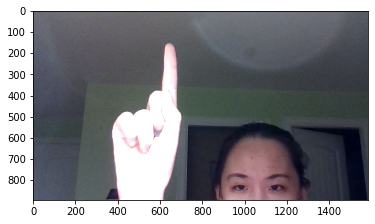

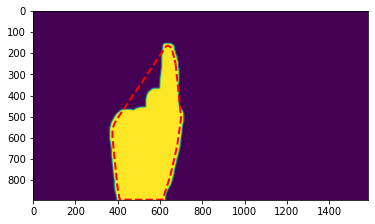

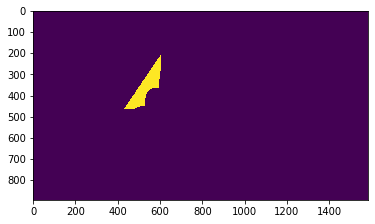

number of fingers is 2


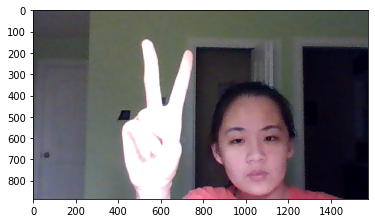

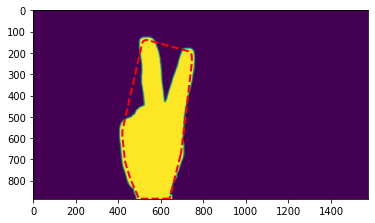

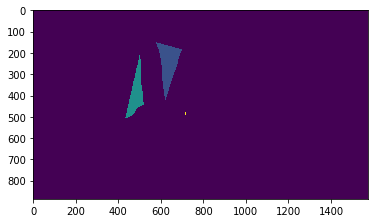

number of fingers is 2


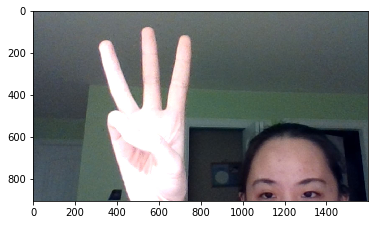

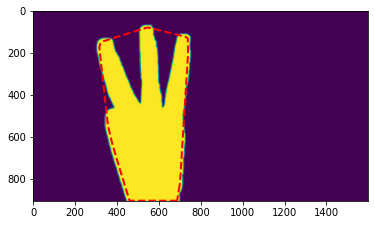

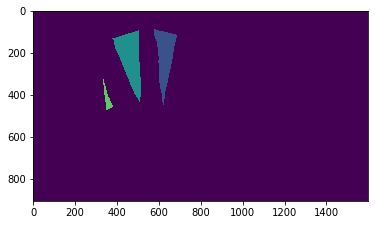

number of fingers is 3


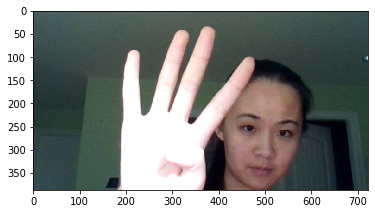

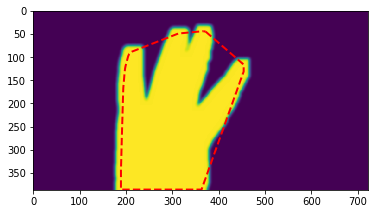

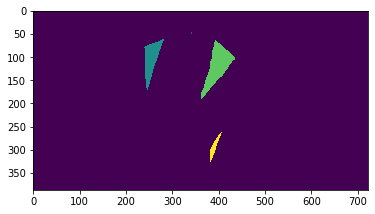

number of fingers is 3


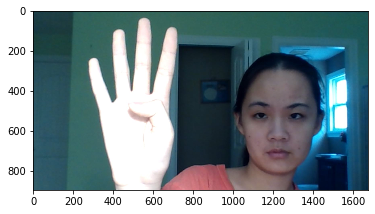

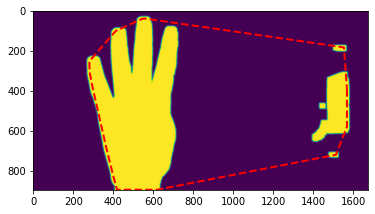

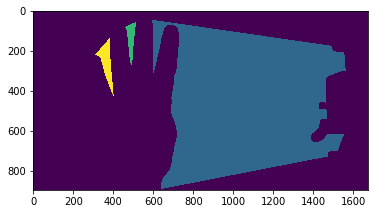

number of fingers is 4


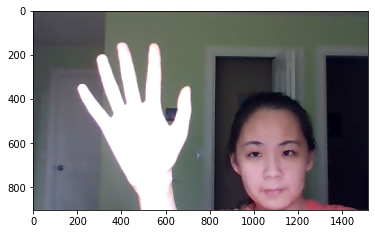

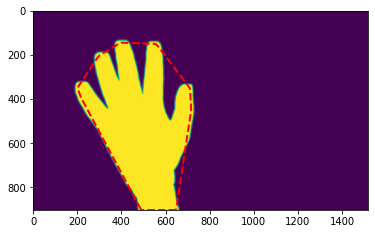

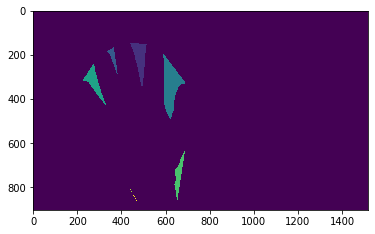

number of fingers is 5


In [5]:
img_names = ['1.jpg', '2.jpg', '3.jpg', '4.jpg', '4.2.jpg', '5.jpg']

for img_n in img_names:

    img1 = cv2.imread(img_n, cv2.IMREAD_COLOR)
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    plt.imshow(img1)
    plt.show()

    detect_fingers(img1)
